## LightweightMMM 에 Gemini 적용하기

by JeongMin Kwon (cojette@gmail.com)

LightweightMMM을 사람들이 더 손쉽게 활용하고 바로 마케팅에 적용할 수 있도록 일부 요소에 Gemini API를 적용하여 보다 쉬운 형태의 MMM(Marketing Mix Model)을 만듭니다.

* LightweightMMM: https://github.com/google/lightweight_mmm
* Gemini AI Studio : https://ai.google.dev/


In [1]:
## !pip install --upgrade pip
!pip3 install --upgrade git+https://github.com/google/lightweight_mmm.git
!pip3 install numpyro==0.13.1
import pandas as pd
from lightweight_mmm import preprocessing, lightweight_mmm, plot, optimize_media
import jax.numpy as jnp
from sklearn.metrics import mean_absolute_percentage_error


  Cloning https://github.com/google/lightweight_mmm.git to /var/tmp/pip-req-build-zrpj7767
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /var/tmp/pip-req-build-zrpj7767
  Resolved https://github.com/google/lightweight_mmm.git to commit 4406aaa77bddc5b0d73d31c6cf4f2ace03f3ffda
  Preparing metadata (setup.py) ... done


2024-04-23 12:07:59.628677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-23 12:07:59.630444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-23 12:07:59.630450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
!pip3 install google-cloud
!pip3 install google-oauth

import glob
from google.cloud import bigquery
from google.oauth2 import service_account


credential = service_account.Credentials.from_service_account_file([Your BigQuery Key file])


# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credential,
                         project = credential.project_id)

## 데이터 가져옴
sql = """
SELECT
    *,
    CASE
    WHEN Date LIKE '% 2021' THEN
      PARSE_DATE('%b %d, %Y', REPLACE(Date, ' "', ''))
    WHEN Date LIKE '%/2021' THEN
      PARSE_DATE('%m/%d/%Y', Date)
    ELSE
      NULL END AS Ad_Date
   FROM adanalysis.campaigndata
    """

query_job = client.query(sql)

# 데이터프레임으로 변환
df = query_job.to_dataframe()
df.head()

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


,Date,Brand_Alias,Ad_group_alias,ASIN_SKU_Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised_Units_sold,Other_SKU_units_sold,Advertised_SKU_Sales,Other_SKU_sales,Ad_Date
0,"Nov 08, 2021",Brand 1,Brand 1 Ad Group 1,ASIN374,Walmart,1168,23,7.37,0.0,0,0,0,0,0.0,0.0,2021-11-08
1,"Nov 12, 2021",Brand 1,Brand 1 Ad Group 1,ASIN374,Walmart,0,0,0.00,0.0,0,0,0,0,0.0,0.0,2021-11-12
2,"Nov 13, 2021",Brand 1,Brand 1 Ad Group 13,ASIN374,Walmart,1712,12,2.18,0.0,0,0,0,0,0.0,0.0,2021-11-13
3,"Nov 14, 2021",Brand 1,Brand 1 Ad Group 13,ASIN374,Walmart,1014,4,0.70,0.0,0,0,0,0,0.0,0.0,2021-11-14
4,"Nov 19, 2021",Brand 1,Brand 1 Ad Group 13,ASIN374,Walmart,1308,17,3.11,0.0,0,0,0,0,0.0,0.0,2021-11-19


In [4]:
# 구글 생성 AI 연동 및 차트 이미지 처리를 위해 필요한 라이브러리를 가져옴
!pip3 install -U -q google-generativeai

import google.generativeai as genai

import base64
import io
import json
import mimetypes
import pathlib
import pprint
import requests

import PIL.Image
import IPython.display
from IPython.display import Markdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Gemini for EDA 

LightWeightMMM에서는 따로 데이터를 확인하는 과정이 없으나, 데이터를 파악하는 과정은 데이터 분석에서 가장 중요합니다. 데이터를 확인한 후 필요시 일부 데이터는 필터링하거나 보완할 수 있습니다. 

여기서는 Gemini를 사용해서 모든 사용자가 데이터의 현황을 확인 가능하도록 자동으로 간단하게 EDA를 해서 문서 형태로 확인할 수 있도록 합니다. 

이 때 이 데이터가 MMM에 사용되는 것을 고려하여 해당 맥락에 맞춘 문서를 만들도록 합니다. 

In [4]:
# 구글 생성 AI 연동 및 차트 이미지 처리를 위해 필요한 라이브러리를 가져옴
!pip3 install -U -q google-generativeai

import google.generativeai as genai

import base64
import io
import json
import mimetypes
import pathlib
import pprint
import requests

import PIL.Image
import IPython.display
from IPython.display import Markdown

API_KEY = [Gemini API Key]
genai.configure(api_key=API_KEY)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:

genaimodel = genai.GenerativeModel(model_name="gemini-1.5-pro-latest")

# 프롬프트 설명 : 데이터에 대한 간단한 배경, 앞으로 활용 용도(MMM), EDA 및 outlier에 대한 의견 요청
prompt_parts = "This data has information about different ad groups that were set for brands in a few marketplaces like Walmart. It's from BigQuery.  This data are usually organized by Campaign, Ad Group (or Ad Set), and Ads. A campaign can have many ad groups that target different groups of people. For example, one ad group can be for people that subscribed to the e-mail list, another for people that visited sites. Then, inside each ad group, we have the ads that people in that group will see. We can have many ads, with different messages and formats (video vs image). We never really know which campaign or ad group will be the best before running. It’s normal to launch multiple ad groups and after a few days turn off the ones that are not reaching our goals (like paying too much for someone to install an app). This time, we have to analyze this data. It's very crucial for us. First of all, please Do a simple EDA with this data and find outlier rows that are unlikely to be utilized in the marketing mix model. Thanks in advance."

# 모델 설정
generation_config = {
  "temperature": 2,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 9999
}

# 데이터와 함께 해당 프롬프트를 Gemini에 전달
response = genaimodel.generate_content([prompt_parts, df.to_csv()], generation_config=generation_config)


In [6]:
## 한글 번역 요청

response2 = genaimodel.generate_content(["다음 내용을 한국어로 바꿔줘. ", response.text], generation_config=generation_config)

In [7]:
import textwrap

from IPython.display import display
from IPython.display import Markdown

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## 마크다운으로 표시
to_markdown(response2.text)

> ## 탐색적 데이터 분석 (EDA) 및 이상치 탐지
> 
> 제공된 데이터를 기반으로 기본적인 EDA 및 이상치 탐지 분석을 진행해보겠습니다.
> 
> **데이터 개요:**
> 
> *   데이터는 8037개의 행과 16개의 열로 구성되어 있습니다.
> *   Walmart, eBay, Amazon 및 익명의 마켓플레이스까지 총 4개의 마켓플레이스에서 두 브랜드의 광고 성과를 추적합니다.
> *   데이터는 2021년 10월 17일부터 2022년 1월 11일까지의 기간을 포함합니다.
> *   주요 지표에는 노출수, 클릭수, 지출, 판매, 주문, 판매된 상품 수(광고된 상품 및 기타 상품) 및 판매액(광고된 상품 및 기타 상품)이 포함됩니다.
> 
> 
> **데이터 정리**
> 496번째 행의 날짜 형식에 불일치가 있는 것으로 보입니다. 분석을 진행하기 전에 데이터 정확성을 위해 이러한 문제를 먼저 해결해야 합니다.
> 
> 
> **EDA 관찰 사항**
> *   **누락된 값:** 일부 행에서 노출수, 클릭수, 지출, 판매, 주문 및 상품 수에 0값이 있습니다.  이는 비활성 캠페인, 광고 그룹 또는 광고를 나타낼 수 있습니다. 이를 더 자세히 조사해야 합니다.
> *   **분포:** 지출, 판매 및 클릭수와 같은 주요 지표의 분포를 히스토그램 또는 상자 그림을 사용하여 분석하면 잠재적 이상치와 데이터의 전체적인 모양을 파악할 수 있습니다.
> 
> **잠재적 이상치:**
> 
> 다음과 같은 방법을 사용하여 이상치를 탐지할 수 있습니다.
> 
> *   **사분위수 범위 (IQR):** 지출, 판매, 클릭수 및 판매된 상품 수와 같은 지표에 대한 IQR을 계산합니다. 제1사분위수 아래 1.5배 IQR 또는 제3사분위수 위 1.5배 IQR 범위를 벗어나는 데이터 포인트를 잠재적 이상치로 식별합니다.
> *   **Z-점수:** 이러한 지표에 대한 Z-점수를 계산하고 Z-점수가 3보다 크거나 -3보다 작은 데이터 포인트를 잠재적 이상치로 간주합니다.
> 
> **추가 조사 필요 사항:**
> 
> 1.  **0값 행:** 비활성 캠페인과 잠재적으로 잘못된 데이터 입력을 구분해야 합니다. 마케팅 믹스 모델에 포함하거나 제외할지에 대한 정보에 입각한 결정을 내리기 위해 0값 행의 맥락을 조사해야 합니다.
> 2.  **맥락적 이상치:** 통계적 방법 외에도 도메인 지식과 캠페인 목표를 고려하여 이상치를 식별합니다. 예를 들어, 캠페인의 목표에 따라 지출이 높고 판매가 낮은 경우 이상치로 간주될 수 있습니다.
> 
> **도구 및 라이브러리**
> 
> *   **Pandas 및 NumPy와 같은 Python 라이브러리는 데이터 조작 및 분석에 매우 유용합니다.**
> *   **Matplotlib 및 Seaborn과 같은 라이브러리는 데이터 시각화에 도움이 됩니다.**
> *   **SciPy와 같은 통계 라이브러리는 이상치 탐지 기능을 제공합니다.**
> 
> **다음 단계:**
> *   **각 지표에 대한 시각화를 통해 EDA를 심화합니다.**
> *   **통계적 이상치 탐지 기술을 활용합니다.**
> *   **통계적 이상치 탐지와 도메인 지식을 결합합니다.**
> 
> 철저한 EDA 및 이상치 분석을 통해 광고 성과 데이터에 대한 귀중한 통찰력을 얻고 마케팅 믹스 모델에서 추가 조사 또는 제외가 필요한 행을 식별할 수 있습니다.


## 데이터 정제

MMM에 사용할 수 있는 형태로 데이터를 만듭니다. 데이터를 다듬고, 데이터셋을 훈련 데이터와 검정 데이터로 구분합니다. 

In [8]:
## Data Aggregation
agg_data = df.groupby(["Ad_Date", "Ad_group_alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train

media_data_raw = agg_data['Impressions'].unstack().fillna(0)
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Ad_Date").sum()


In [10]:
import numpy as np

## Make random noises
organic_raw = pd.DataFrame({'organic_search': 0, 'organic_social': 0}, index=media_data_raw.index)
organic_raw['organic_search'] = sales_raw['Sales'].values/10 + np.random.randint(10000, 100000, organic_raw.shape[0])
organic_raw['organic_social'] = sales_raw['Sales'].values/10 + np.random.randint(10000, 100000, organic_raw.shape[0])

### 데이터 스케일링

LightweightMMM에서는 sklearn 기반의 내부의 Scaler를 제공합니다. 대부분의 경우 3~4개의 Scaler가 필요합니다. 미디어 데이터용 Scaler 하나, 타겟용 Scaler, 비용용 Scaler. 선택적으로 추가 기능을 추가하는 경우 추가 스케일러가 필요할 수 있습니다. LighweightMMM에서는 여러 군데에서 Scaler가 사용되고, 이를 사용해서 여러 단계에서 값을 조율할 수 있습니다.



In [11]:

## Divide Training data and test data with timestamp
split_point = pd.Timestamp("2021-12-15") # 28 days to end of data

media_data_train = media_data_raw.loc[:split_point - pd.Timedelta(1,'D')]
media_data_test = media_data_raw.loc[split_point:]


organic_data_train = organic_raw.loc[:split_point - pd.Timedelta(1,'D')]
organic_data_test = organic_raw.loc[split_point:]

target_train = sales_raw.loc[:split_point - pd.Timedelta(1,'D')]
target_test = sales_raw.loc[split_point:]

costs_train = costs_raw.loc[:split_point - pd.Timedelta(1,'D')].sum(axis=0).loc[media_data_train.columns]

## Scale data with mean()
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
organic_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(
    divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

### data transformation for model
media_data_train_scaled = media_scaler.fit_transform(media_data_train.values.astype(int))
organic_data_train_scaled = organic_scaler.fit_transform(organic_data_train.values)
target_train_scaled = target_scaler.fit_transform(target_train['Sales'].values.squeeze())
costs_scaled = cost_scaler.fit_transform(costs_train.values.astype(int))

media_data_test_scaled = media_scaler.transform(media_data_test.values.astype(int))
organic_data_test_scaled = organic_scaler.transform(organic_data_test.values)

media_names = media_data_raw.columns

## 모델링 

여기서는 adstock, hill_adstock, carryover 의 세 가지 모델을 제공합니다. 각각의 모델은 media별 사전 확률을 활용하는 수식과 계절성 활용 정도에 따라 구분됩니다. 

In [12]:

#adstock_models = ["adstock", "hill_adstock", "carryover"]
#degrees_season = [1,2,4]

adstock_models = ["carryover"]
degrees_season = [1]

## model fitting
for model_name in adstock_models:
  for degrees in degrees_season:
    mmm = lightweight_mmm.LightweightMMM(model_name=model_name)
    mmm.fit(media=media_data_train_scaled,
            media_prior=costs_scaled,
            target=target_train_scaled,
            extra_features=organic_data_train_scaled,
            number_warmup=10,
            number_samples=1000,
            number_chains=1,
            degrees_seasonality=degrees,
            weekday_seasonality=True,
            seasonality_frequency=365,
            seed=1)

    ## Prediction
    prediction = mmm.predict(
    media=media_data_test_scaled,
    extra_features=organic_data_test_scaled,
    target_scaler=target_scaler)
    p = prediction.mean(axis=0)
    
    ## Calculate error rate
    mape = mean_absolute_percentage_error(target_test['Sales'].values, p)
    print(f"model_name={model_name} degrees={degrees} MAPE={mape} samples={p[:3]}")

sample: 100%|██████████| 1010/1010 [06:26<00:00,  2.61it/s, 1023 steps of size 2.53e-03. acc. prob=0.91]


model_name=carryover degrees=1 MAPE=0.11528897073300037 samples=[29842.932 31098.863 31916.115]


In [14]:
!python -m pip3 uninstall matplotlib
!pip3 install matplotlib
!pip3 install arviz

import arviz

/opt/conda/bin/python: No module named pip3


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightweight-mmm 0.1.9 requires matplotlib==3.6.1, but you have matplotlib 3.8.4 which is incompatible.
ydata-profiling 4.6.0 requires matplotlib<=3.7.3,>=3.2, but you have matplotlib 3.8.4 which is incompatible.


In [15]:
media_data_train.head()

Ad_group_alias,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,Brand 1 Ad Group 7,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6
Ad_Date,,,,,,,,,,,,,,,,,,,
2021-10-17,3317,33,50966,9519,40265,0,142704,55,94,1054,248,23321,276437,424883,135366,41905,9871,0,0
2021-10-18,1501,30,39424,14015,18545,0,389663,53,121,1669,283,28321,313907,492277,119675,46550,19920,50619,0
2021-10-19,771,63,236572,16543,13078,0,810070,58,122,1795,245,26105,296159,475287,191075,0,9253,43019,0
2021-10-20,958,70,277649,24590,10743,0,821705,60,111,948,234,0,314952,641517,98214,61017,18669,45642,0
2021-10-21,1841,59,251202,14236,10799,0,1241204,72,150,739,394,0,392621,412898,88922,121214,12977,69165,0


## 결과 해석 및 모델 설명

기본으로 제공하는 그래프도 베이지안 사전 지식이나 분포 사전 지식 등이 필요하고 모델에 대한 이해가 있어야 하므로 그래프를 기반으로 Gemini에게 설명을 맡겨서 그래프와 함께 내용을 같이 확인할 수 있도록 합니다.


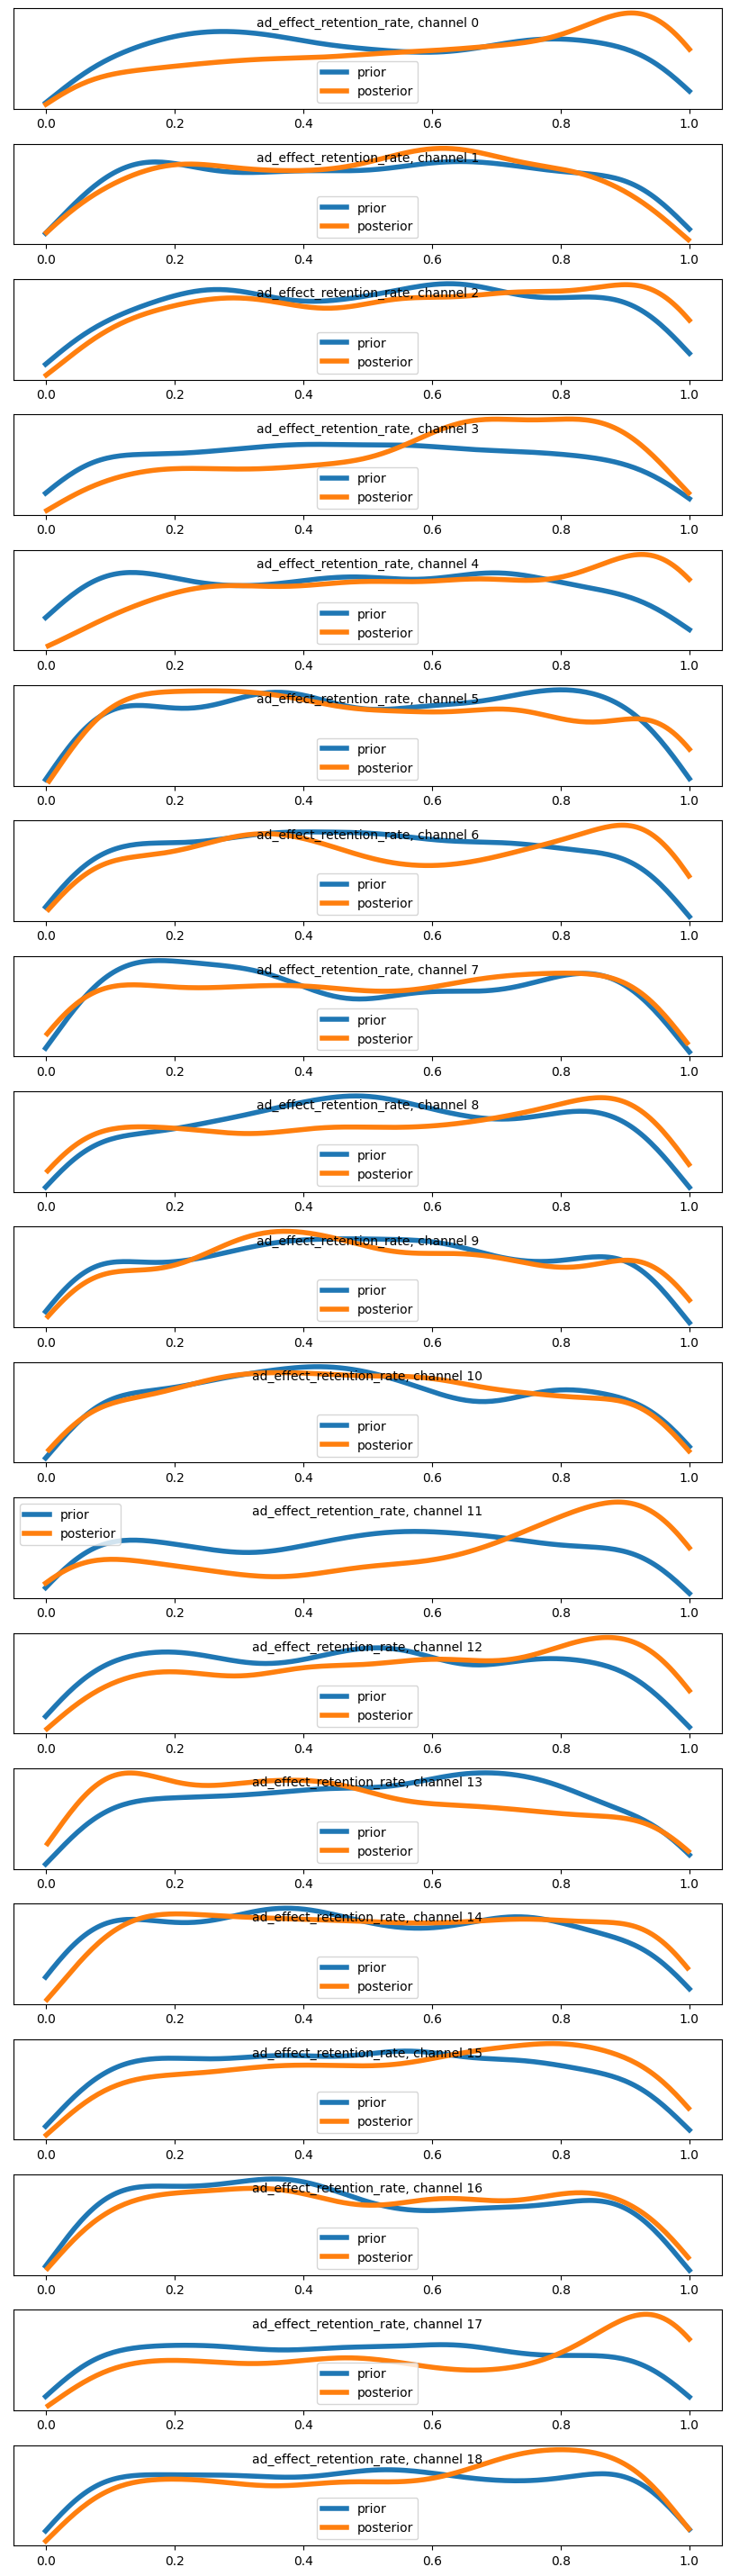

In [23]:
## plot the prior and posterior distributions for every model parameter (It's very long and I chose only one feature
!pip install matplotlib==3.1.3

plt = plot.plot_prior_and_posterior(media_mix_model=mmm, number_of_samples_for_prior = 1000,selected_features = ['ad_effect_retention_rate'])
fig = plt.get_figure()

In [25]:
fig.savefig("plot_media_posterior.png", bbox_inches = "tight")

In [26]:
# plot the estimated media contributions with their respective credibility intervals

media_effect_hat, roi_hat = mmm.get_posterior_metrics()
plt = plot.plot_bars_media_metrics(metric = media_effect_hat, channel_names=media_names)
fig = plt.get_figure()
fig.savefig("plot_media_hat.png", bbox_inches = "tight")
plt = plot.plot_bars_media_metrics(metric = roi_hat, channel_names=media_names)
fig = plt.get_figure()
fig.savefig("plot_roi_hat.png", bbox_inches = "tight")

In [27]:
##  plot the curve response of all media channels  that how each media channel behaves individually as we invest more in it.
plt = plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=1)
fig = plt.get_figure()
fig.savefig("plot_res_curve.png", bbox_inches = "tight")

In [43]:
from pathlib import Path
import hashlib

uploaded_files = []
def upload_if_needed(pathname: str) -> list[str]:
  path = Path(pathname)
  hash_id = hashlib.sha256(path.read_bytes()).hexdigest()
  try:
    existing_file = genai.get_file(name=hash_id)
    return [existing_file]
  except:
    pass
  uploaded_files.append(genai.upload_file(path=path, display_name=hash_id))
  return [uploaded_files[-1]]


## 프롬프트: 앞에서 그린 그래프에 대해 간략히 설명하고 이를 그래프 4종류를 업로드함. 이를 바탕으로 결과를 해석하는 것을 요첨함
prompt_parts = [
  "These graphs are from marketing mix model result.", 
  "First graph shows an visualize the prior and posterior distributions for every channel that ads effect to the retention rate at once. Note that we use a kernel density estimator to smooth these distributions for easier interpretability; you may need to adjust the bandwidth of the smoother depending on the shapes of your distributions.", 
  "Second plot is also about media effect metrics. Third plot is the ROI plot. These plots take into account not only the media effect but how much it costs to get this effect. Another vital question we can solve with MMMs is how each media channel behaves individually as we invest more in it. ",
  "For that we plot the curve response of all media channels. It is the fourth plot. ", 
  " I hope you read and understand these graphes and write a report about insights from these graphes and help us make decisions about our marketing advertising budget.",
  *upload_if_needed('plot_media_posterior.png'),
  *upload_if_needed("plot_media_hat.png"),
  *upload_if_needed("plot_roi_hat.png"),
  *upload_if_needed("plot_res_curve.png"),
  "Please be as helpful as possible in describing your interpretation of the graph and what you can do with it. Thanks in advance.  ",
]
response = genaimodel.generate_content(prompt_parts, generation_config=generation_config)
to_markdown(response.text)
for uploaded_file in uploaded_files:
  genai.delete_file(name=uploaded_file.name)


In [44]:
response2 = genaimodel.generate_content(["다음 내용을 한국어로 바꿔줘. ", response.text], generation_config=generation_config)
to_markdown(response2.text)

> ## 마케팅 믹스 모델 그래프를 통한 인사이트
> 
> 제공된 그래프를 기반으로 마케팅 광고 예산에 대한 인사이트와 잠재적 행동 방안을 제시합니다.
> 
> **1. 리텐션율에 대한 채널 효과**
> 
> * **상당한 변화:** 첫 번째 그래프 세트는 여러 채널(예: 0, 1, 2, 3, 4, 7, 8, 10, 12)에 대해 사전 및 사후 분포에서 상당한 변화를 나타냅니다. 이는 이러한 채널이 사용자 리텐션에 상당한 영향을 미친다는 것을 시사합니다.
> * **영향력이 큰 채널에 집중:**  사후 분포 변화가 큰 채널에 예산을 더 많이 할당합니다. 이러한 채널은 사용자 리텐션 측면에서 투자 대비 가장 효과적인 수익을 제공할 가능성이 높습니다.
> * **영향력이 낮은 채널 분석:** 변화가 적은 채널(예: 5, 6, 9, 11, 13-18)의 실적이 저조한 이유를 조사합니다. 잘못된 타겟층을 타겟팅하고 있는지, 크리에이티브 개선이 필요한지 고려합니다. 예산 할당을 줄이거나 제거하는 것도 고려할 수 있습니다. 
> 
> **2. 미디어 채널 메트릭**
> 
> * **다양한 성과:** 두 번째 및 세 번째 그래프는 다양한 브랜드 및 광고 그룹에 걸쳐 다양한 성과를 보여줍니다.
> * **최고 실적 채널 식별:**  브랜드 1 광고 그룹 2, 8, 9, 브랜드 2 광고 그룹 1, 브랜드 1 광고 그룹 13이 특히 효과적인 것으로 보입니다. 이러한 최고 실적 그룹에 대한 투자를 늘려 수익을 극대화합니다.
> * **저성과 채널 조사:**  브랜드 2 내의 여러 그룹(그룹 1 제외)이 저조한 성과를 보이는 것으로 보입니다. 타겟팅, 크리에이티브 또는 플랫폼 선택과 관련된 잠재적 문제를 분석합니다. 
> 
> **3. 투자 수익률(ROI)**
> 
> * **비용 효율성:** 미디어 효과 메트릭을 관련 비용과 비교하여 ROI를 확인합니다.
> * **ROI가 높은 채널 우선 순위 지정:** 비용 대비 더 높은 영향을 미치는 채널에 더 많은 예산을 할당합니다. 
> * **ROI가 낮은 채널 평가:** 영향력이 적은 채널의 가치를 재평가합니다. 개선하거나 더 효율적인 대안으로 교체하는 것을 고려합니다.
> 
> **4. 반응 곡선 및 포화점**
> 
> * **수익 감소:** 반응 곡선은 대부분의 채널에서 지출이 증가함에 따라 수익이 감소한다는 것을 나타냅니다. 곡선이 평평해지기 시작하는 지점을 식별합니다. 이는 추가 지출이 최소한의 추가 가치만 제공하는 포화점을 나타냅니다.
> * **예산 할당 최적화:**  반응 곡선을 기반으로 채널 전체에 예산을 효과적으로 분배하여 포화된 채널에 과도하게 지출하지 않도록 합니다. 포화점에 도달하기 전에 성장 가능성이 더 큰 채널에 리소스를 할당하는 것을 고려합니다.
> 
> ##  권장 사항:
> 
> * **영향력이 큰 채널 우선 순위 지정:**  리텐션에 명확한 영향을 미치고 높은 ROI를 제공하는 채널에 집중합니다.
> * **저성과 채널 분석 및 개선:** 저성과 이유를 조사하고 타겟팅, 크리에이티브 또는 플랫폼 선택을 조정하는 것을 고려합니다. 개선이 불가능한 경우 예산을 줄이거나 재할당하는 것을 고려합니다.
> * **채널 간 지출 균형 조정:**  반응 곡선을 활용하여 최적의 예산 할당을 결정하고 포화된 채널에 과도하게 지출하지 않도록 합니다.
> * **지속적인 모니터링 및 최적화:**  MMM 결과를 정기적으로 검토하여 변화하는 추세를 식별하고 그에 따라 전략을 조정합니다. 마케팅 역학은 끊임없이 진화하므로 성과를 면밀히 모니터링하고 광고 예산의 효과를 극대화하기 위해 필요한 조정을 하는 것이 중요합니다.
> * **A/B 테스트:**  각 채널 내에서 크리에이티브 및 타겟팅에 대한 A/B 테스트를 구현하여 지속적으로 접근 방식을 개선하고 사용자 참여 및 리텐션을 유도하는 가장 효과적인 전략을 찾습니다. 
> * **새로운 채널 탐색:**  기존 채널 최적화도 중요하지만, 새로운 플랫폼 및 광고 기회를 계속 탐색하여 도달 범위를 넓히고 미개척 성장 잠재력을 찾습니다.
> 
> **MMM 그래프에서 도출된 인사이트를 이해하고 권장 조치를 취함으로써 마케팅 광고 예산 할당을 최적화하고 전반적인 투자 수익률을 개선할 수 있습니다. 중요한 것은 데이터와 인사이트를 기반으로 전략을 조정하고 진화하여 지속적인 성장과 성공을 달성하는 것입니다.**


## 예산 최적화

주어진 효과를 모델에서 파악한 정도에 따라서 최적으로 채널별 예산을 분배함

In [30]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = 50
budget = prices * media_data_raw.mean(axis=0)* n_time_periods

In [ ]:
budget.values

In [31]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
#    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget= sum(budget.values), 
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    max_iterations = 10,
    seed=1)

Iteration limit reached    (Exit mode 9)
            Current function value: -1221434.2232126403
            Iterations: 10
            Function evaluations: 390
            Gradient evaluations: 10


In [32]:
optimal_budget_allocation = prices * solution.x
optimal_budget_allocation

Array([1.8138123e+05, 1.5976272e+03, 3.5399325e+06, 9.6180550e+05,
       1.2558749e+06, 1.6089025e+04, 2.2025936e+07, 2.3277966e+03,
       2.2135391e+04, 3.0623887e+04, 2.5937266e+04, 4.4038316e+05,
       1.7143198e+07, 2.7503898e+07, 5.2502715e+06, 1.2654630e+06,
       9.4129756e+05, 4.5192731e+05, 7.2550044e+03], dtype=float32)

In [33]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([1.8144233e+05, 1.3068665e+03, 3.5400882e+06, 9.6188694e+05,
       1.2560151e+06, 1.5516024e+04, 2.2026096e+07, 1.9041487e+03,
       2.1957188e+04, 3.0444750e+04, 2.5856990e+04, 4.4047894e+05,
       1.7143356e+07, 2.7504058e+07, 5.2504270e+06, 1.2656100e+06,
       9.4143300e+05, 4.5207431e+05, 7.3828389e+03], dtype=float32)

In [34]:
# Both these values should be very close in order to compare KPI
budget, optimal_budget_allocation.sum()

(Ad_group_alias
 Brand 1 Ad Group 1     1.920586e+05
 Brand 1 Ad Group 10    1.138158e+03
 Brand 1 Ad Group 11    3.619405e+06
 Brand 1 Ad Group 13    9.962368e+05
 Brand 1 Ad Group 2     1.276094e+06
 Brand 1 Ad Group 3     1.324145e+04
 Brand 1 Ad Group 4     2.130917e+07
 Brand 1 Ad Group 5     2.119079e+03
 Brand 1 Ad Group 6     2.053619e+04
 Brand 1 Ad Group 7     2.956250e+04
 Brand 1 Ad Group 8     2.742961e+04
 Brand 1 Ad Group 9     4.544428e+05
 Brand 2 Ad Group 1     1.714358e+07
 Brand 2 Ad Group 2     2.833384e+07
 Brand 2 Ad Group 3     5.259764e+06
 Brand 2 Ad Group 4     1.021999e+06
 Brand 2 Ad Group 5     1.000211e+06
 Brand 1 Ad Group 14    3.575290e+05
 Brand 2 Ad Group 6     8.969079e+03
 dtype: float32,
 Array(81067336., dtype=float32))

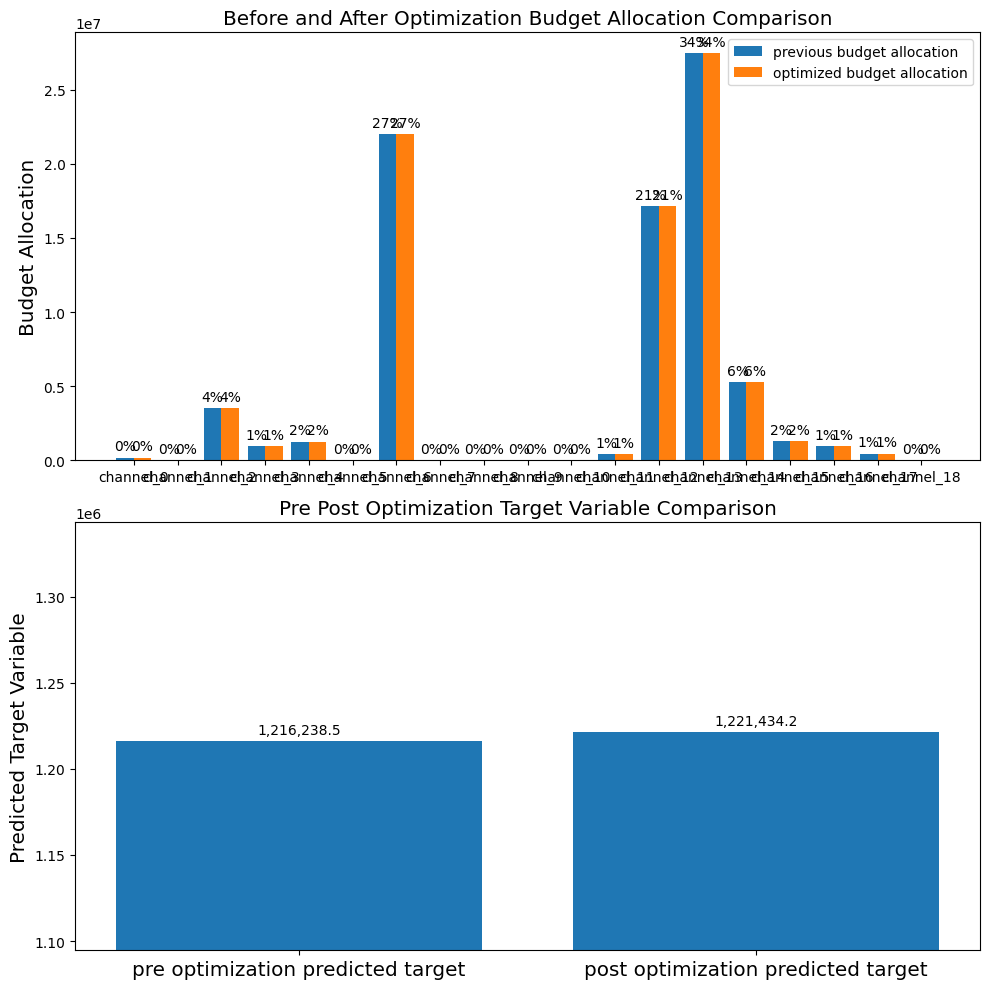

In [36]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_budget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10))

## 모델 저장

모델을 저장해두고 재활용할 수 있습니다. 

In [ ]:
from lightweight_mmm import utils

# We can use the utilities for saving models to disk.
file_path = "media_mix_model.pkl"
utils.save_model(media_mix_model=mmm, file_path=file_path)

## 예산 최적화에 대한 비교 설명

예산 최적화 결과와 이전 예산안을 비교한 후에 이에 대해서 자동으로 파악을 할 수 있습니다.
(여기서 사용한 데이터에는 적합하지 않아서 생략함) 

In [ ]:
','.join(budget.index)
#np.array2string(budget.index, separator=',')[1: len(np.array2string(budget.index, separator=','))-1]

In [ ]:
## budget이 어려운 경우에 설명. 여기서는 거의 비슷한 결과가 나왔으므로 생략함. 

prompt_parts = [
  "Here's the optimal budget allocation using this marketing mix model, and the second value is the existing budget allocation, and the third value is the ad group name index for each of these. Compare the two and write a nice report about what you think we should do in the future. And then I'll do what you want. Thank you very much.    ",
    np.array2string(optimal_budget_allocation, separator=',')[1: len(np.array2string(optimal_buget_allocation, separator=','))-1],
    np.array2string(previous_budget_allocation, separator=',')[1: len(np.array2string(optimal_buget_allocation, separator=','))-1] ,
    ','.join(budget.index)
]
response = genaimodel.generate_content(prompt_parts, generation_config=generation_config)
to_markdown(response.text)

In [ ]:
response2 = genaimodel.generate_content(["다음 내용을 한국어로 바꿔줘. ", response.text], generation_config=generation_config)
to_markdown(response2.text)